<a href="https://colab.research.google.com/github/prateekjoshi565/movie_genre_prediction/blob/master/Movie_Genre_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will start by importing the required libraries. 

In [0]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

### Load Data

Now we will import the data uploaded to our Google drive. I will introduce you to a new method to connect the google drive to a colab environment.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Let's load the movie metadata first. Please use '\t' as the separator as it is a tab separated file. 

In [0]:
file_path = "/content/drive/My Drive/AV Articles/movie_genre/movie.metadata.tsv"
meta = pd.read_csv(file_path, sep = '\t', header = None)

In [0]:
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


There are no headers in this dataset. The first column is the **unique movie id**, the third column is the **name of the movie**, and the last column is the **movie genre(s)**. Let's add column names to these columns. We will not use rest of the columns in this analysis.

In [0]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

Now we will load the **movie plot dataset** into memory. This data comes in a text file with each row consisting a pair of a movie id and a plot of the movie. We will read it line-by-line.

In [0]:
file_path_2 = "/content/drive/My Drive/AV Articles/movie_genre/plot_summaries.txt"
plots = []

with open(file_path_2, 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

42303it [00:04, 8812.80it/s]


We will then split the movie ids and the plots into 2 separate lists. These lists will then be used to form a dataframe.

In [0]:
movie_id = []
plot = []

for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

100%|██████████| 42303/42303 [00:00<00:00, 902808.39it/s]


In [0]:
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

Let's see what we have got.

In [0]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


So, we have movie id and movie plot in this dataframe. Next we will add movie names and movie genres from the movie metadata by merging the latter to the former based on the column *movie_id*.

### Data Exploration and Pre-processing

In [0]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

In [0]:
movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


Great! We have added both movie names and genres. However, the genres are in dictionary notation. It will easier to work with it if we can somehow convert into python list. Let's try to do it with the first sample.

In [0]:
movies['genre'][0]

'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

We can't access the genres in this sample just by using *.values( )* just like how we do it with a dictionary because it is not actually a dictionary but a string. So, we will have to convert this string into a dictionary. We will take help of the **json library** here.

In [0]:
type(json.loads(movies['genre'][0]))

dict

As you can see, now it is a python dictionary and we ca easily access its genres by using the following code.

In [0]:
json.loads(movies['genre'][0]).values()

dict_values(['Drama', 'World cinema'])

We can use this code to extract all the genres from the movies data. After that we will add the extracted genres as lists of genres back to the movies dataframe.

In [0]:
genres = []

for i in movies['genre']:
  genres.append(list(json.loads(i).values()))
    
movies['genre_new'] = genres

Some of the samples might contain no genre tags. Hence, we should take those samples out as they won't help much in model building.

In [0]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [0]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

Only 411 samples had no genre tags. Let's check out the dataframe once again. 

In [0]:
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


The genres are now in the list format which is going to be helpful since we will have to access these genre tags later. 

If you are curious to know which all movie genres have been covered in this dataset, then the following code will be useful for you.

In [0]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

There are over 363 unique genre tags in our dataset. That is quite a big number. I can hardy recall 5-6 genres. So, let's find out what are these tags. We will use **FreqDist( )** of the nltk library to create a dictionary of genres and their occurence count across the dataset.

In [0]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

Sometimes visualizing data is better than putting out numbers. Let's plot the distribution of the movie genres.

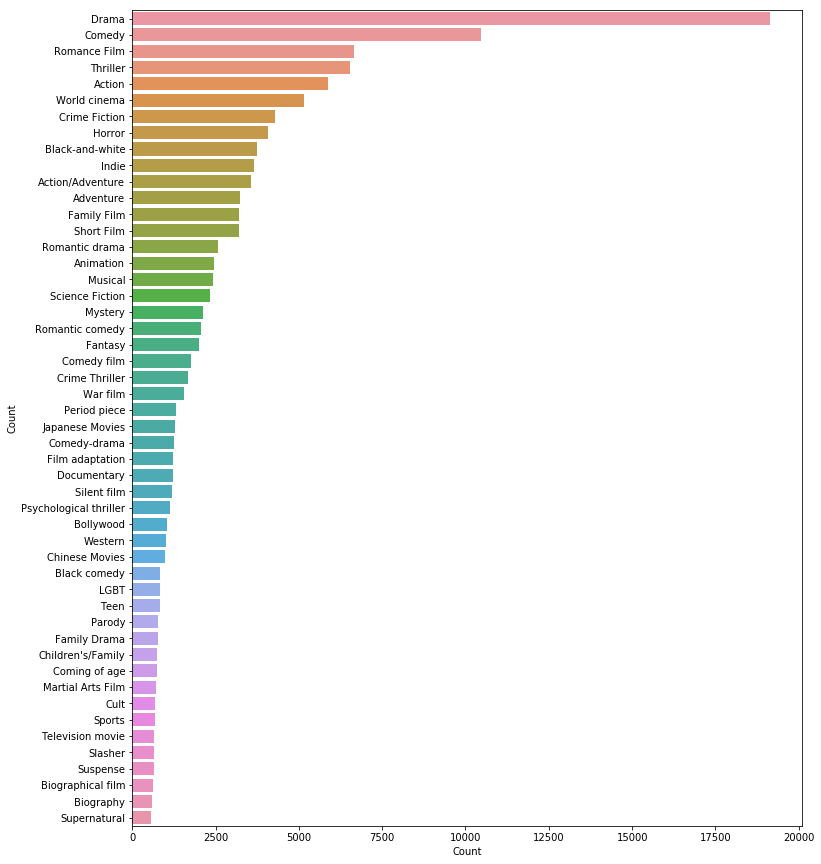

In [0]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

As expected, the most frequent tags are "Drama", "Comedy", "Romance", "Thriller", and "Action". The rest of the genres in the data are in some way or other derived from the top 5 genres. 

So, now you can decide whether you want to work with a certain number of most frequent genres or all the genres. As I am solving this problem for the first time, I'd consider all the 363 genres.

Next we will clean our a bit. I will use some very basic text cleaning steps as that is not the focus area of this article.

In [0]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    
    return text

Let's apply the function on the movie plots by using the apply-lambda duo.

In [0]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Feel free to check the new vs old movie plots. Given below are a few random samples.

In [0]:
movies_new[['plot', 'clean_plot']].sample(3)

,plot,clean_plot
37021,"The commercial towing spaceship Nostromo is on a return trip from Thedus to Earth, hauling a refinery and twenty million tons of mineral ore, and carrying its seven-member crew in stasis. Upon receiving a transmission of unknown origin from a nearby planetoid, the ship's computer awakens the cre...",the commercial towing spaceship nostromo is on a return trip from thedus to earth hauling a refinery and twenty million tons of mineral ore and carrying its seven member crew in stasis upon receiving a transmission of unknown origin from a nearby planetoid the ships computer awakens the crew in ...
33256,"The film follows Laud Weiner, an oblivious, self-satisfied, and spoiled Hollywood manager-producer, as he explains his 'hard' work to the camera while in reality taking credit for other people's ideas and making everyone's life difficult.",the film follows laud weiner an oblivious self satisfied and spoiled hollywood manager producer as he explains his hard work to the camera while in reality taking credit for other peoples ideas and making everyones life difficult
31187,"Ganesh is an orphan who always pitches in to help needy people. In one such strange situation, he is forced to act with Divya that he loves her. But later on, she comes to know that he is loving her to fulfill some other ambition and his love is an act of fabrication. By then, Ganesh genuinely...",ganesh is an orphan who always pitches in to help needy people in one such strange situation he is forced to act with divya that he loves her but later on she comes to know that he is loving her to fulfill some other ambition and his love is an act of fabrication by then ganesh genuinely falls i...


In the clean_plot column the text is in lowercase and there is also no punctuation mark. So, our text cleaning has worked like a charm. This function below can visualize the words with their frequencies, in a set of documents. Let's use it to find out the most frequent words in the movie plots.

In [0]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

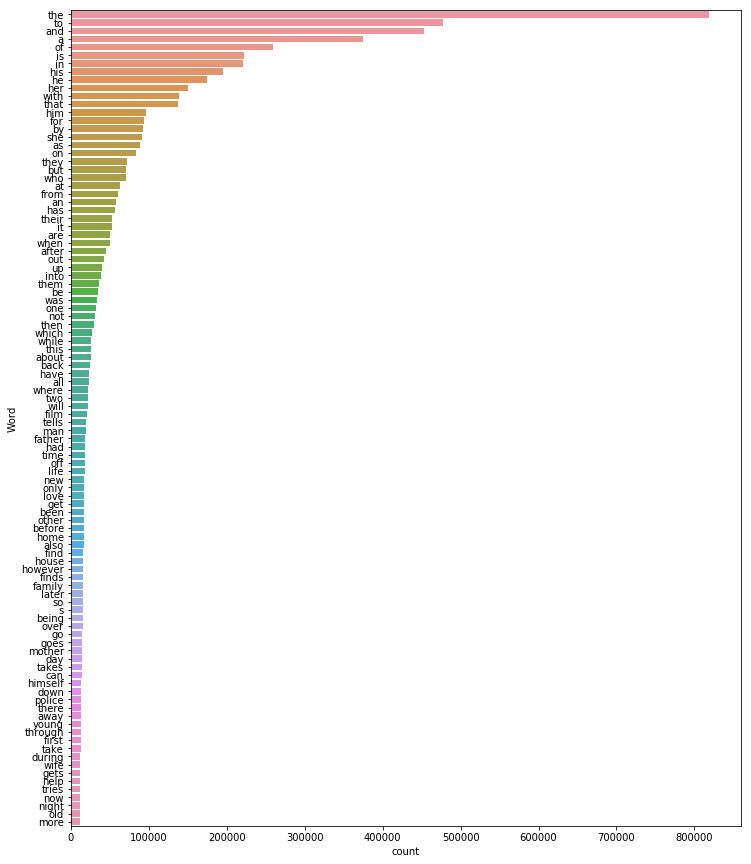

In [0]:
# print 100 most frequent words
freq_words(movies_new['clean_plot'], 100)

Most of the terms in the plot above are stopwords. These stopwords carry less important meaning than other keywords in the text. Therefore, we will remove them from the plots' text. You would have to download the list of stopwords from the nltk library.

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Now we can remove the stopwords.

In [0]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's again check the most frequent words after the stopwords removal.

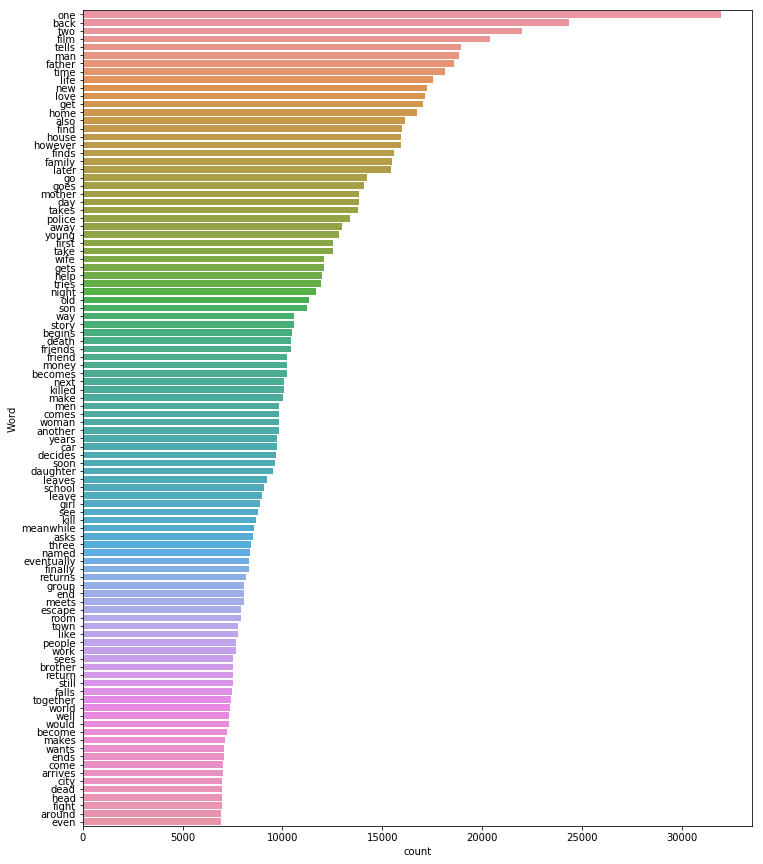

In [0]:
freq_words(movies_new['clean_plot'], 100)

As it turns out, more interesting words have now emerged, such as "police", "family", "money", "city" and many more. 

### Converting Text to Features

I have earlier mentioned in the article that I will treat this multilable classification problem as a Binary Relevance problem. Hence, now I am going to one hot encode the target variable, i.e. *genre_new* by using sklearn's **MultiLabelBinarizer( )**. Since there are 363 unique genre tags, there are going to be 363 new target variables.

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

We have successfully transformed the target variable and now let's turn our focus to extract features from the cleaned version of the movie plots. I have decided to go ahead with TF-IDF features. You are free to use any other feature extraction method such as Bag-of-Words, word2vec, GloVe, or ELMo. 


I recommend you check out these articles to learn more about different ways of creating features from text:



*   [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
*   [A Step-by-Step NLP Guide to Learn ELMo for Extracting Features from Text](https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/)



In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

Please note that I have used the 10,000 most frequent words in the data as my features. You can try any other number as well for the parameter max_features. Before creating TF-IDF features, we will split our data into train and validation sets for training our and evaluating its performance, respectively. 80% of the data samples have been kept in the train set and the rest of the data is in the validation set.

In [0]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

Now we can create features for the train and the validation set.

In [0]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

### Build Your Movie Genre Prediction Model

As we have already discussed earlier, if we are using the Binary Relevance approach to solve a multilable problem, then we will have to one hot encode the target variable and then build model for each and every one hot encoded target variables. Since we have 363 target variables, we will have to fit 363 different models with the same set of predictors (TF-IDF features). 

Training 363 models can take a considerable amount of time on a modest system. Hence, I will go ahead with the Logistic Regression model as it is quick to train and easy on the limited hardware.

In [0]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

We will use sklearn's OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem.

In [0]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

Finally we are going to fit our model on the train set

In [0]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 245 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

Once our model is trained, we can then predict movie genres for the validation set. Let's do it.

In [0]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

Let's check out a prediction...

In [0]:
y_pred[3]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

It is a binary one dimensional array of length 363. Basically it is the one hot encoded form of the unique genre tags. We will have to find some way to convert it into movie genre tags. Luckily, sklearn is bcak to our rescue once again. We will use **inverse_transform( )** function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into movie genre tags.

In [0]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Action', 'Drama')

Wow! That was smooth.

However, to evaluate our model's overall performance, we will have to take into consideration all the predictions and the entire target variable of the validation set.

In [0]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.31539641943734015

We get a decent F1 score of 0.315. These predictions were made based on a threshold value of 0.5, which means that the probabilities greater than or equal to 0.5 were converted to 1's and the rest to 0's. Let's try to change this threshold value and see if that helps our model.

In [0]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

Now set a threshold value.

In [0]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

I have tried 0.3 as the threshold value. You may try any other value as well. Let's check the F1 score again on these new predictions.

In [0]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.4378456703198025

That is a big boost to the performance. A better approach to find the right threshold value would be to use a k-fold cross validation setup and try different threshold values.

### Create Inference Function

Our job is still not over. We have trained our model and we have also made predictions for the validation set. However, we also have to take care of the new data or new movie plots that would come in future. Our movie genre prediction system should be able to take a movie plot in raw form as input and give out its genre tags as output.

To achieve this objective, let's build an inference function. It will take in a movie plot text and follow the steps below:



*   Clean the text
*   Remove stopwords from the cleaned text
*   Extract features from the text
*   Make predictions
*   Return the predicted movie genre tags




In [0]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

Let's test this inference function on a few samples from the validation set.

In [0]:
for i in range(5):
    k = xval.sample(1).index[0]
    print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")   

Movie:  The Other Me 
Predicted genre:  [('Comedy', 'Family Film')]
Actual genre:  ['Family Film', 'Fantasy', 'Comedy'] 

Movie:  Paperman 
Predicted genre:  [()]
Actual genre:  ['Short Film', 'Animation'] 

Movie:  Teheran 43 
Predicted genre:  [('Drama',)]
Actual genre:  ['Thriller', 'Crime Fiction', 'Drama', 'War film', 'Romance Film', 'Action'] 

Movie:  To Aru Hikūshi e no Tsuioku 
Predicted genre:  [()]
Actual genre:  ['Anime'] 

Movie:  Half Human 
Predicted genre:  [('Horror',)]
Actual genre:  ['Japanese Movies', 'Science Fiction', 'Horror', 'Creature Film'] 

